In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from PIL import Image

# System & Utility Libraries
from pathlib import Path
import os
import random
import cv2
import itertools

In [2]:
dataset = r"D:\Neural_Project\Snake_Img_Dataset36"
def walk_through_dir(dataset):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dataset):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
walk_through_dir(dataset)

There are 35 directories and 0 images in 'D:\Neural_Project\Snake_Img_Dataset36'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\agkistrodon-contortrix'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\agkistrodon-piscivorus'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\coluber-constrictor'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\crotalus-atrox'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\crotalus-horridus'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\crotalus-ruber'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\crotalus-scutulatus'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\crotalus-viridis'.
There are 0 directories and 500 images in 'D:\Neural_Project\Snake_Img_Dataset36\diadophis-punctatus'.


In [4]:
# Set manual seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# For model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
sns.set_style('darkgrid')

# Device configuration
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")

In [6]:
print(device)

xpu


In [7]:
import os
import random
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ✅ Folder where your original data is stored
data_root = r"D:\Neural_Project\Snake_Img_Dataset36"  # 🔁 Modify if needed
target_count = 500
image_extensions = (".jpg", ".jpeg", ".png")

# ✅ Define augmentation pipeline
augmentation_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(20, translate=(0.1, 0.1)),
])

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ✅ Process each class folder
for class_name in os.listdir(data_root):
    class_path = os.path.join(data_root, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_extensions)]
    image_count = len(images)

    print(f"\n📁 Class: {class_name} | Existing images: {image_count}")

    if image_count >= target_count:
        print("✅ No augmentation needed.")
        continue

    needed = target_count - image_count
    print(f"🔁 Augmenting {needed} images to reach {target_count}...")

    for i in tqdm(range(needed), desc=f"Augmenting {class_name}"):
        original_img_name = random.choice(images)
        original_img_path = os.path.join(class_path, original_img_name)

        try:
            image = Image.open(original_img_path).convert("RGB")
            augmented = augmentation_transforms(image)
            augmented = to_pil(to_tensor(augmented))

            aug_filename = f"aug_{i:05d}_{original_img_name}"
            aug_save_path = os.path.join(class_path, aug_filename)
            augmented.save(aug_save_path)

        except Exception as e:
            print(f"❌ Error augmenting {original_img_name}: {e}")


📁 Class: agkistrodon-contortrix | Existing images: 500
✅ No augmentation needed.

📁 Class: agkistrodon-piscivorus | Existing images: 500
✅ No augmentation needed.

📁 Class: coluber-constrictor | Existing images: 500
✅ No augmentation needed.

📁 Class: crotalus-atrox | Existing images: 500
✅ No augmentation needed.

📁 Class: crotalus-horridus | Existing images: 500
✅ No augmentation needed.

📁 Class: crotalus-ruber | Existing images: 500
✅ No augmentation needed.

📁 Class: crotalus-scutulatus | Existing images: 500
✅ No augmentation needed.

📁 Class: crotalus-viridis | Existing images: 500
✅ No augmentation needed.

📁 Class: diadophis-punctatus | Existing images: 500
✅ No augmentation needed.

📁 Class: haldea-striatula | Existing images: 500
✅ No augmentation needed.

📁 Class: heterodon-platirhinos | Existing images: 500
✅ No augmentation needed.

📁 Class: lampropeltis-californiae | Existing images: 500
✅ No augmentation needed.

📁 Class: lampropeltis-triangulum | Existing images: 500


In [8]:
# Step 1: Define dataset root path
image_dir = Path(r"D:\Neural_Project\Snake_Img_Dataset36")

# Step 2: Gather image filepaths (jpg, png, JPG, etc.)
filepaths = list(image_dir.rglob("*.jpg")) + list(image_dir.rglob("*.JPG")) + \
            list(image_dir.rglob("*.png")) + list(image_dir.rglob("*.PNG"))

# Step 3: Extract class labels (assumes: root/class/image.jpg)
labels = [path.parent.name for path in filepaths]

# Step 4: Create DataFrame
filepaths_series = pd.Series([str(p) for p in filepaths], name="Filepath")
labels_series = pd.Series(labels, name="Label")

image_df = pd.concat([filepaths_series, labels_series], axis=1)

# Optional: preview DataFrame
print(image_df.head())

                                            Filepath                   Label
0  D:\Neural_Project\Snake_Img_Dataset36\agkistro...  agkistrodon-contortrix
1  D:\Neural_Project\Snake_Img_Dataset36\agkistro...  agkistrodon-contortrix
2  D:\Neural_Project\Snake_Img_Dataset36\agkistro...  agkistrodon-contortrix
3  D:\Neural_Project\Snake_Img_Dataset36\agkistro...  agkistrodon-contortrix
4  D:\Neural_Project\Snake_Img_Dataset36\agkistro...  agkistrodon-contortrix


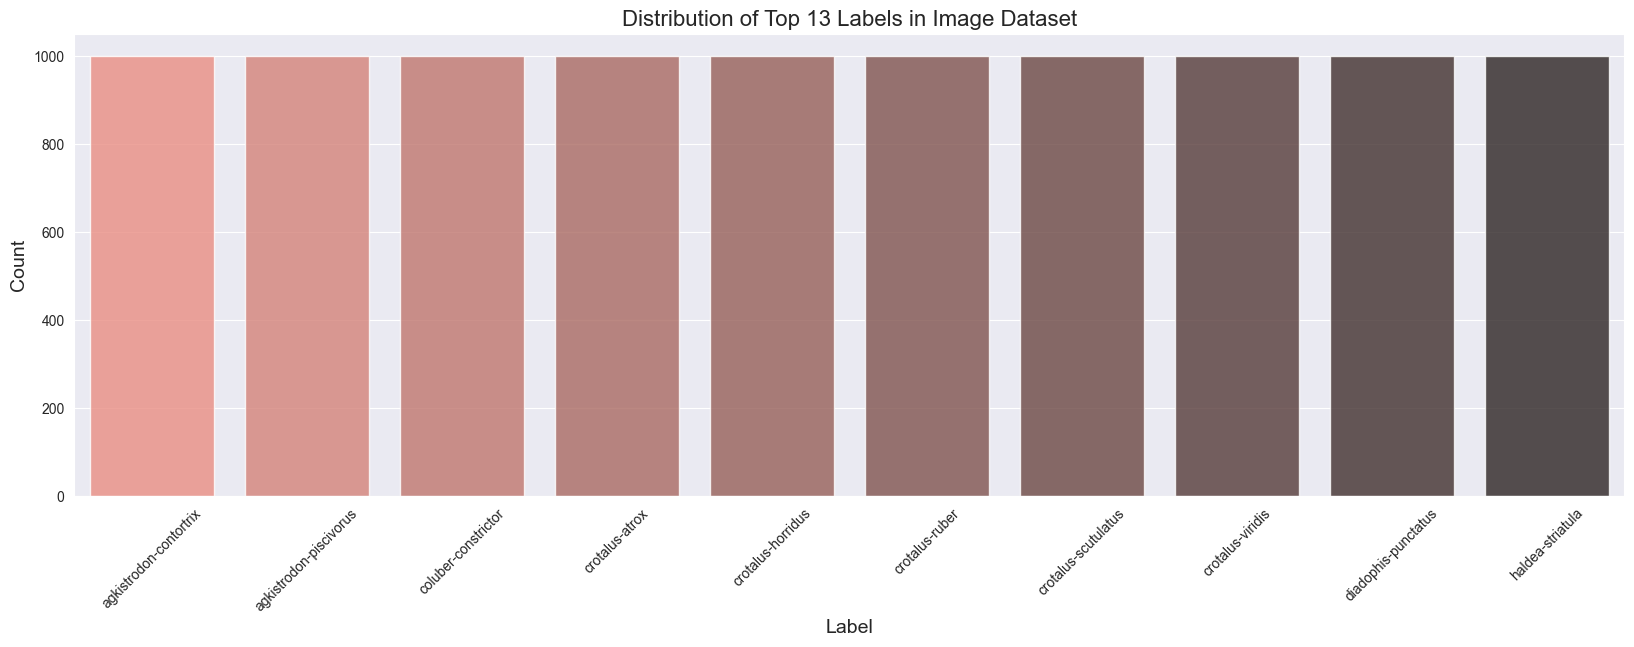

In [9]:
label_counts = image_df['Label'].value_counts()[:10]

plt.figure(figsize=(20, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    alpha=0.8,
    palette='dark:salmon_r',
    legend=False
)
plt.title('Distribution of Top 13 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

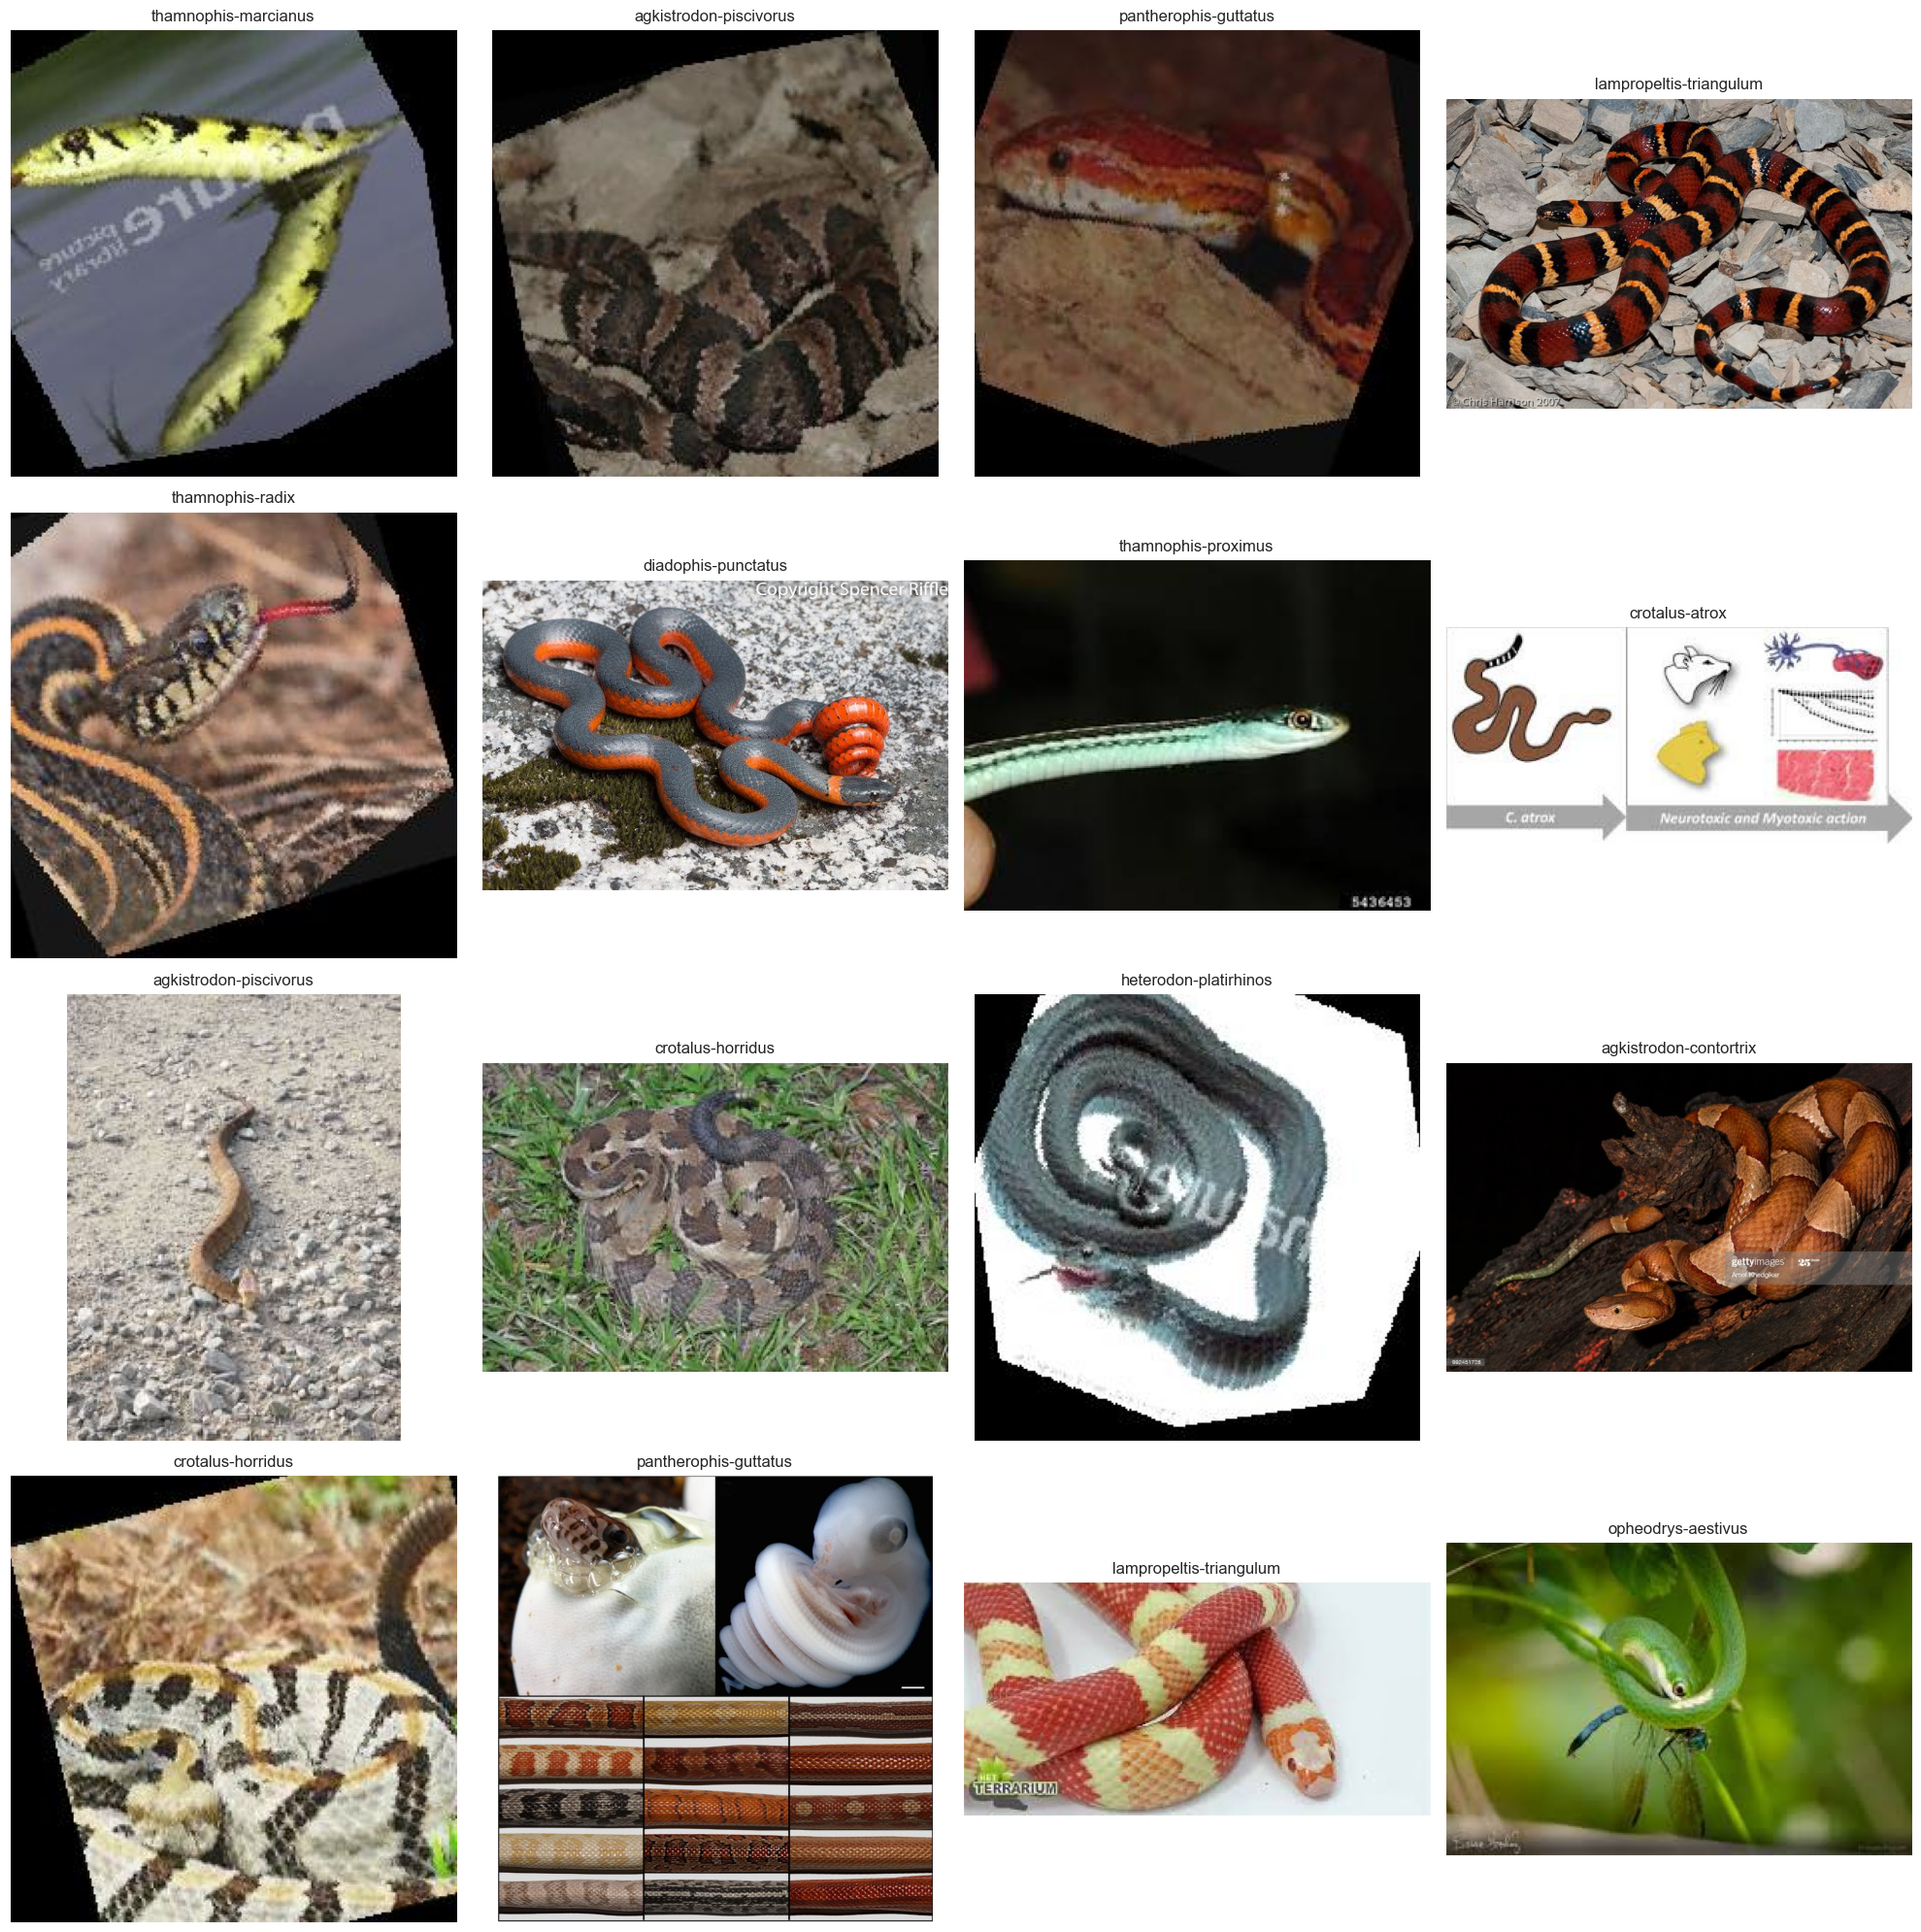

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [11]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_snake36.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

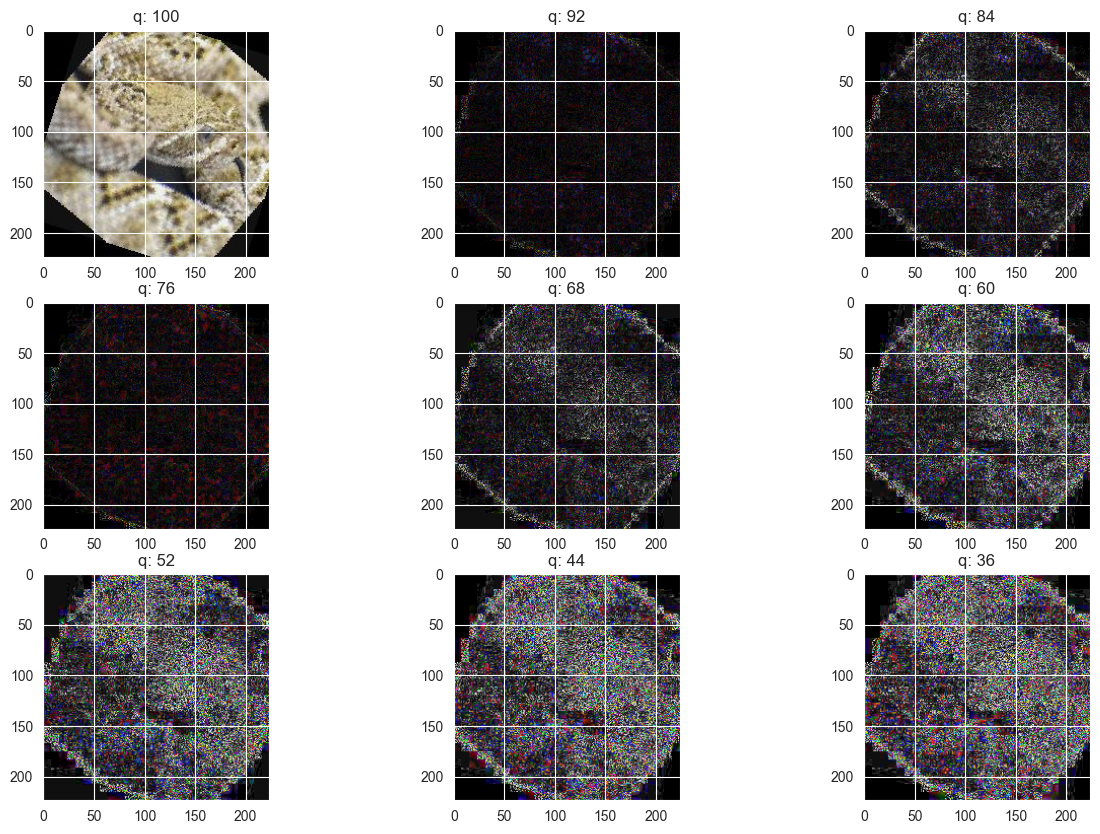

In [12]:
# View random sample from the dataset
p = random_sample(r'D:\Neural_Project\Snake_Img_Dataset36\crotalus-atrox')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [13]:
import os
import torch
import pandas as pd
from PIL import Image
from glob import glob
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ---------------------- Settings ----------------------
DATASET_PATH = r"D:\Neural_Project\Snake_Img_Dataset36"
BATCH_SIZE = 32
NUM_CLASSES = 36
SEED = 42
DEVICE = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ---------------------- Create image_df ----------------------
image_paths = glob(os.path.join(DATASET_PATH, "*", "*.jpg"))  # adjust if using PNG, JPEG
image_df = pd.DataFrame({
    "Filepath": image_paths,
    "Label": [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

le = LabelEncoder()
image_df["Label_encoded"] = le.fit_transform(image_df["Label"])

# ---------------------- Stratified Split ----------------------
train_df, test_df = train_test_split(
    image_df, stratify=image_df["Label_encoded"], test_size=0.2, random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, stratify=train_df["Label_encoded"], test_size=0.2, random_state=SEED
)

# ---------------------- Transforms ----------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------------------- Custom Dataset ----------------------
class SnakeClassifiacationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["Filepath"].values
        self.labels = df["Label_encoded"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------------- Create Datasets ----------------------
train_ds = SnakeClassifiacationDataset(train_df, transform=train_transform)
val_ds = SnakeClassifiacationDataset(val_df, transform=val_test_transform)
test_ds = SnakeClassifiacationDataset(test_df, transform=val_test_transform)

# ---------------------- Class Imbalance Handling ----------------------
class_counts = train_df["Label_encoded"].value_counts().sort_index().values
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df["Label_encoded"]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# ---------------------- DataLoaders ----------------------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

Using device: xpu


In [14]:
import os, random, torch, optuna
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import intel_extension_for_pytorch as ipex


# Set seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if hasattr(torch, 'xpu'):
        torch.xpu.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Device
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "xpu":
    print(f"Intel GPU: {torch.xpu.get_device_name(0)}")

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using device: xpu
Intel GPU: Intel(R) Arc(TM) B580 Graphics


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import optuna
import intel_extension_for_pytorch as ipex

# Intel GPU setup
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)
torch.manual_seed(42)

# ANN Model

class VeryDeepANN(nn.Module):
    def __init__(self, input_size=3 * 224 * 224, num_classes=35):
        super(VeryDeepANN, self).__init__()
        self.input_size = input_size

        self.flatten = nn.Flatten()

        self.block1 = self._block(input_size, 2048, dropout=0.5)
        self.block4 = self._block(2048, 1024, dropout=0.4)
        self.block5 = self._block(1024, 512, dropout=0.4)
        self.block6 = self._block(512, 256, dropout=0.3)
        self.block7 = self._block(256, 128, dropout=0.3)
        self.block8 = self._block(128, 64, dropout=0.3)

        # Residual-style skip connection from input through compression path
        self.shortcut = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final = nn.Sequential(
            nn.Linear(64 + 64, 64),  # Concatenate residual with block8
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def _block(self, in_dim, out_dim, dropout):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.block1(x)
        x4 = self.block4(x1)
        x5 = self.block5(x4)
        x6 = self.block6(x5)
        x7 = self.block7(x6)
        x8 = self.block8(x7)

        shortcut = self.shortcut(x)
        combined = torch.cat((x8, shortcut), dim=1)

        return self.final(combined)

xpu


In [2]:
from torchsummary import summary
model = VeryDeepANN()

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 150528]               0
            Linear-2                 [-1, 2048]     308,283,392
       BatchNorm1d-3                 [-1, 2048]           4,096
              ReLU-4                 [-1, 2048]               0
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

In [16]:
model = VeryDeepANN(input_size=3 * 224 * 224, num_classes=35).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Continue with loss function and training loop
criterion = nn.CrossEntropyLoss()

# Optimize with IPEX for training — pass optimizer explicitly
final_model, optimizer = ipex.optimize(model, optimizer=optimizer)

# Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 20
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    final_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = final_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Epoch 1/20
  Train Loss: 3.5455 | Train Acc: 0.0427
  Val   Loss: 3.5158 | Val   Acc: 0.0561
Epoch 2/20
  Train Loss: 3.4959 | Train Acc: 0.0579
  Val   Loss: 3.4419 | Val   Acc: 0.0711
Epoch 3/20
  Train Loss: 3.4340 | Train Acc: 0.0757
  Val   Loss: 3.3929 | Val   Acc: 0.0793
Epoch 4/20
  Train Loss: 3.3975 | Train Acc: 0.0847
  Val   Loss: 3.3602 | Val   Acc: 0.0868
Epoch 5/20
  Train Loss: 3.3675 | Train Acc: 0.0904
  Val   Loss: 3.3434 | Val   Acc: 0.0957
Epoch 6/20
  Train Loss: 3.3598 | Train Acc: 0.0891
  Val   Loss: 3.3340 | Val   Acc: 0.0907
Epoch 7/20
  Train Loss: 3.3178 | Train Acc: 0.0959
  Val   Loss: 3.3225 | Val   Acc: 0.0896
Epoch 8/20
  Train Loss: 3.3019 | Train Acc: 0.0972
  Val   Loss: 3.3009 | Val   Acc: 0.0993
Epoch 9/20
  Train Loss: 3.3087 | Train Acc: 0.1010
  Val   Loss: 3.2992 | Val   Acc: 0.1014
Epoch 10/20
  Train Loss: 3.2803 | Train Acc: 0.1115
  Val   Loss: 3.2960 | Val   Acc: 0.1079
Epoch 11/20
  Train Loss: 3.2734 | Train Acc: 0.1092
  Val   Loss: 3.

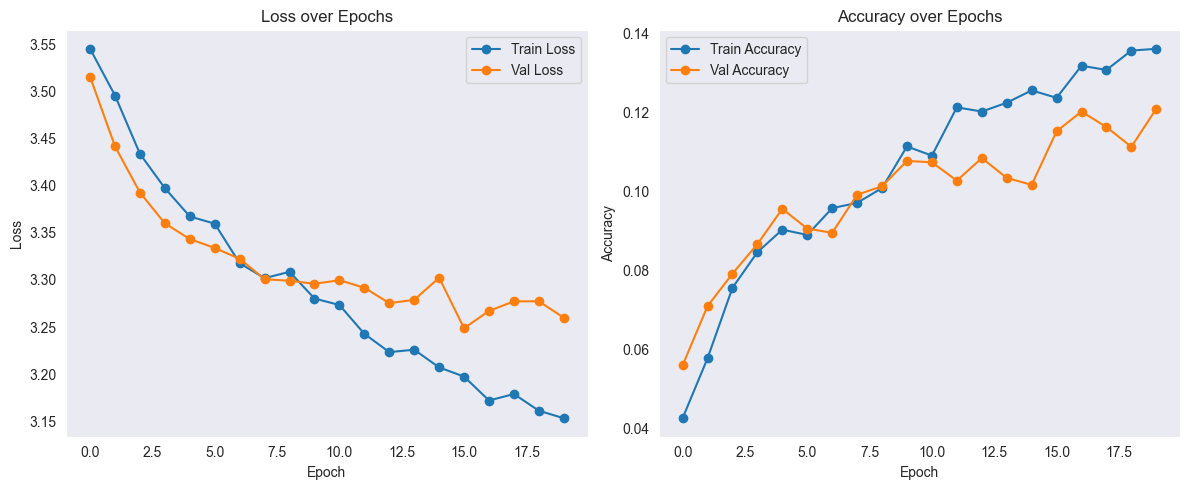

In [17]:
# --- Plotting ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

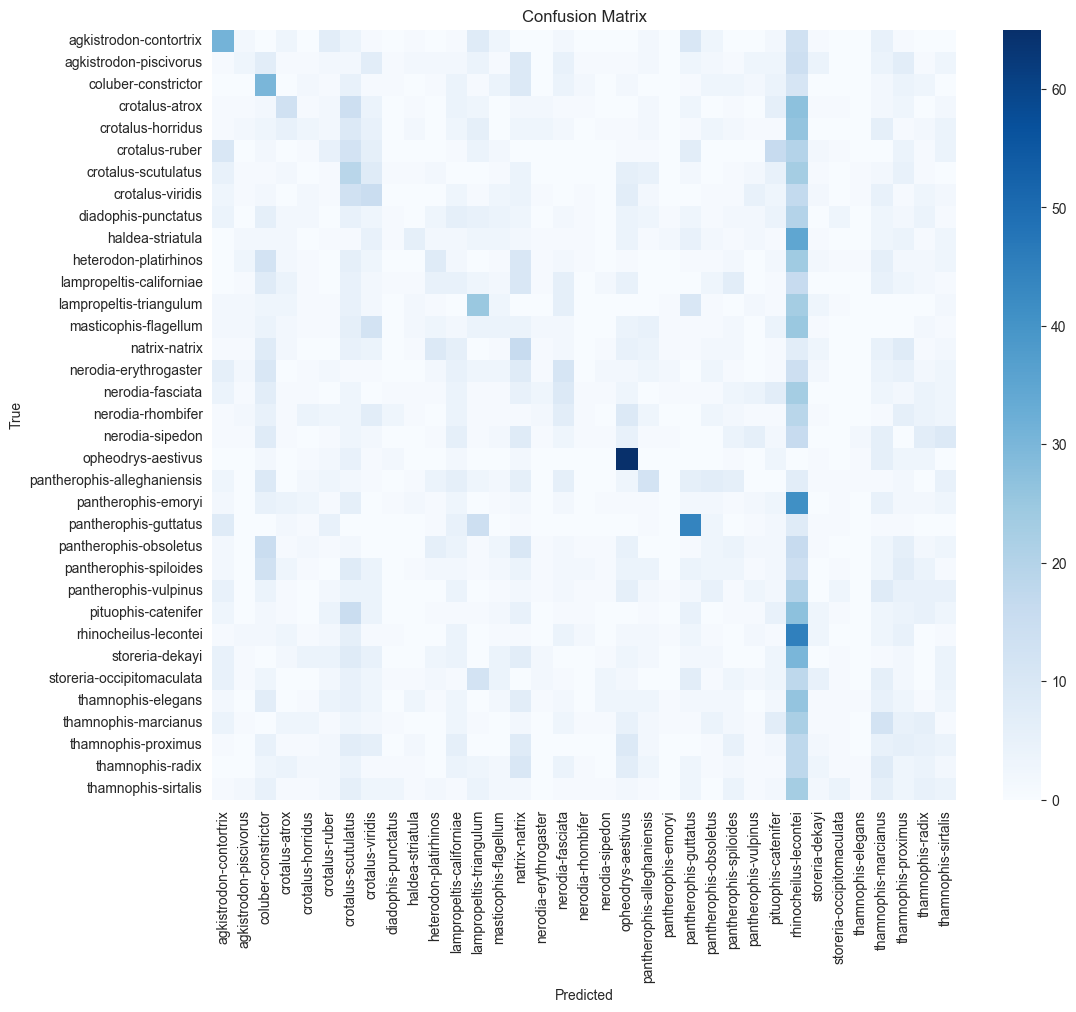

In [18]:
# Evaluate on test set and show confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.26      0.31      0.29       100
     agkistrodon-piscivorus       0.09      0.03      0.04       100
        coluber-constrictor       0.15      0.30      0.20       100
             crotalus-atrox       0.19      0.13      0.15       100
          crotalus-horridus       0.07      0.03      0.04       100
             crotalus-ruber       0.07      0.05      0.06       100
        crotalus-scutulatus       0.09      0.19      0.12       100
           crotalus-viridis       0.12      0.15      0.13       100
        diadophis-punctatus       0.05      0.01      0.02       100
           haldea-striatula       0.18      0.06      0.09       100
      heterodon-platirhinos       0.13      0.08      0.10       100
   lampropeltis-californiae       0.04      0.05      0.05       100
    lampropeltis-triangulum       0.22      0.25      0.23       100
      masticophis-flagellum      

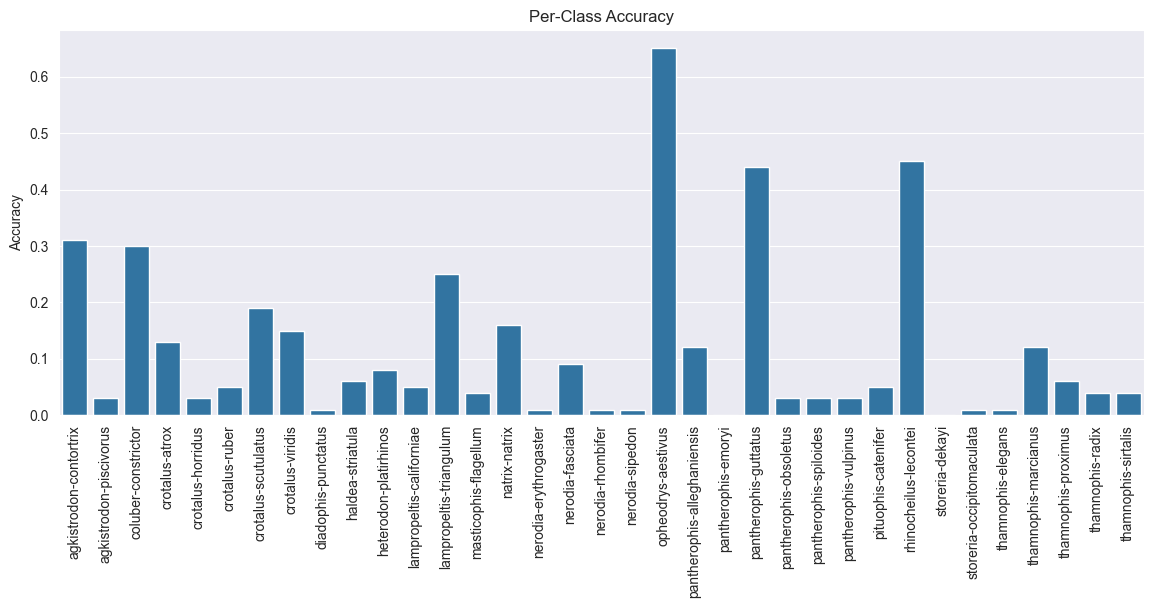

In [21]:
# Classification report and per-class accuracy
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Per-class accuracy bar plot
correct_per_class = cm.diagonal()
total_per_class = cm.sum(axis=1)
per_class_accuracy = correct_per_class / total_per_class

plt.figure(figsize=(14, 5))
sns.barplot(x=le.classes_, y=per_class_accuracy)
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

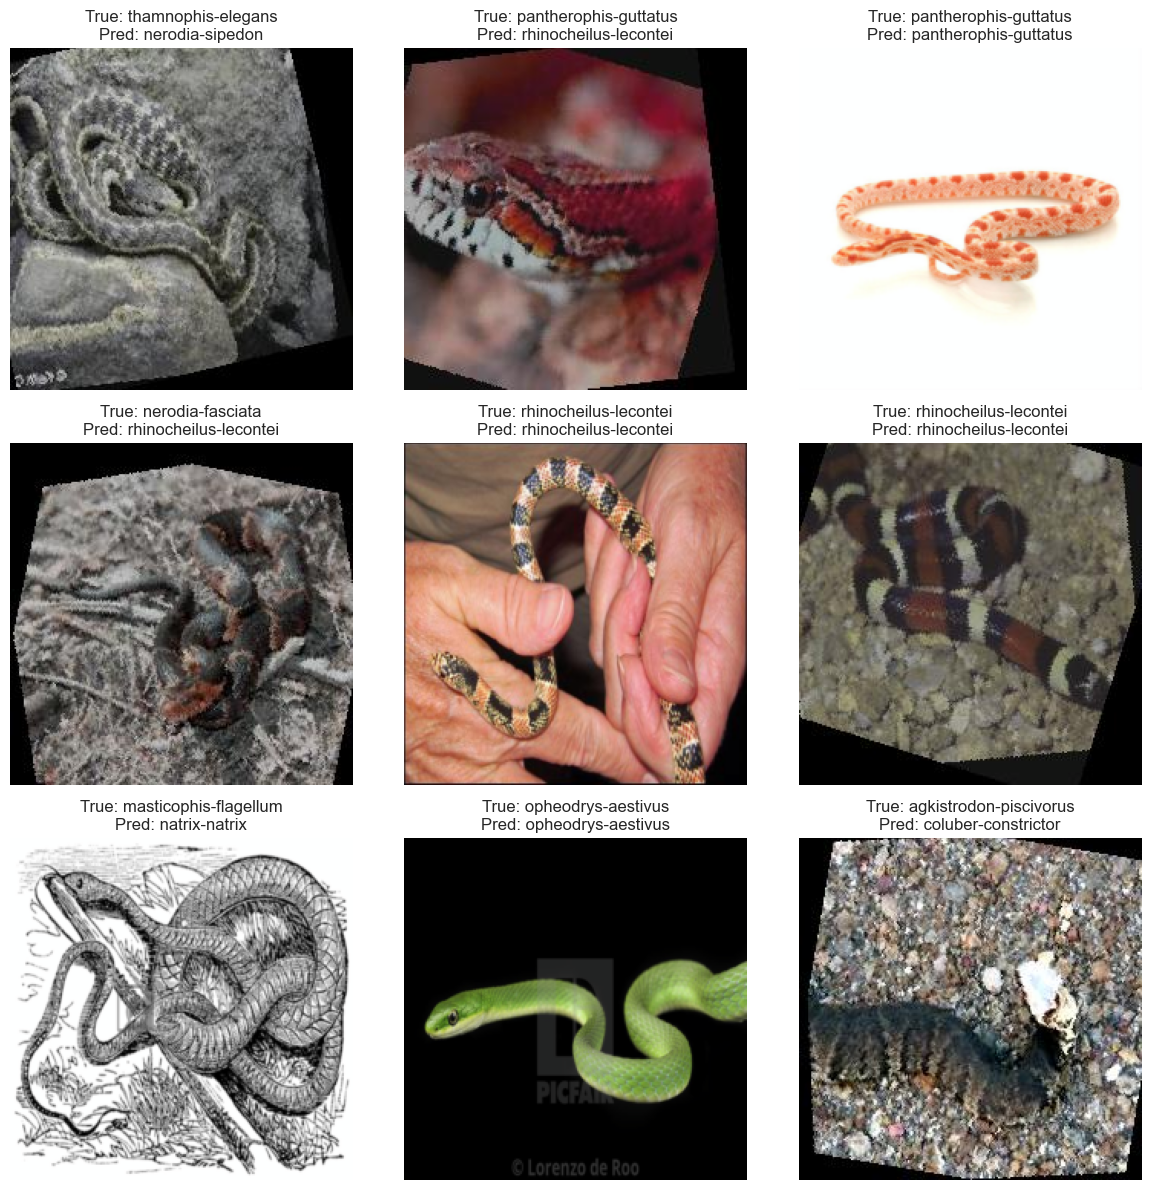

In [22]:
# Show predictions on sample test images
sample_loader = DataLoader(test_ds, batch_size=9, shuffle=True)
images, labels = next(iter(sample_loader))
images = images.to(device)
outputs = final_model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 12))
for i in range(9):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
    img = np.clip(img, 0, 1)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {le.classes_[labels[i]]}\nPred: {le.classes_[preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()